This notebook contains the statistical time series models to forecast bitcoin prices from historical data 

Performed here:
- Explore dataset size, structure, features
- Visualize time series data
- Investigate stationarity, make stationary, decompose the series into components
- Build AR, MA, ARMA, ARIMA, SARIMA models and visualize performance on training data
- Forecast 12 months of bitcoin prices based on the training data and compare with test data

Modifications since last commit:
- Add SARIMA models
- Clean up notebook, fix plotting label errors

In [1]:
# Import libraries
import itertools
import warnings
import math
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Set viewing preferences
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", False)
mpl.rcParams["figure.max_open_warning"] = 50
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load data
data_orig = pd.read_csv("bitcoin_price.csv")
data = data_orig.copy()

# Exploratory Data Analysis & Preprocessing

In [4]:
data.head()

,Timestamp,Close
0,31-12-2011,4.482500
1,31-01-2012,6.208932
2,29-02-2012,5.252514
3,31-03-2012,4.961054
4,30-04-2012,4.976416


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  112 non-null    object 
 1   Close      112 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [6]:
# Convert to pandas datetime and set as index
data["Timestamp"] = pd.to_datetime(data["Timestamp"], format="%d-%m-%Y")
data = data.set_index(["Timestamp"])

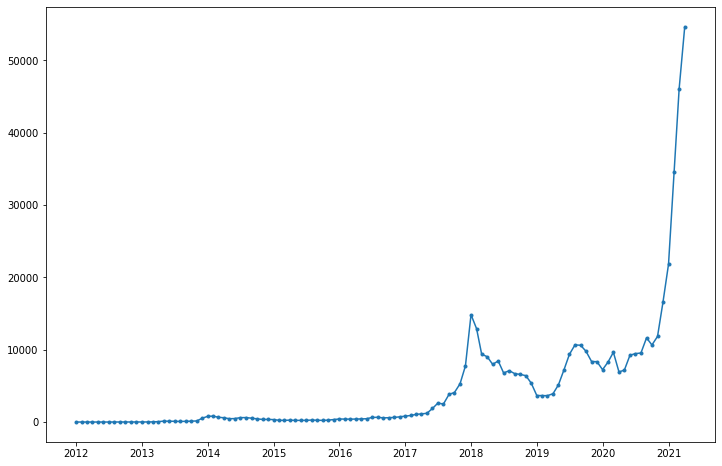

In [7]:
# Plot dataset
plt.figure(figsize=(12,8))
plt.plot(data.index, data.Close, marker=".")
plt.show()

**Split the dataset into train/test**

In [8]:
# Take last 12 months as test data
data_train, data_test = data.iloc[:-12], data.iloc[-12:]

**Investigate stationarity**

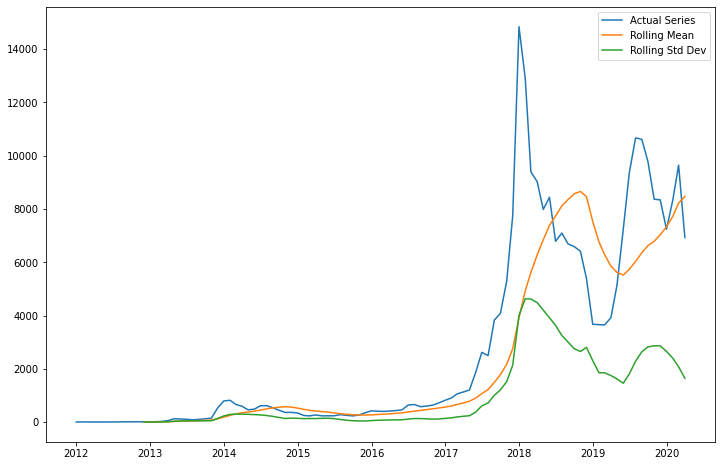

In [9]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean = data_train.rolling(window = 12).mean()
rolstd = data_train.rolling(window = 12).std()

# Visualize the rolling mean and standard deviation
plt.figure(figsize = (12, 8))
actual = plt.plot(data_train, label = "Actual Series")
rollingmean = plt.plot(rolmean, label = "Rolling Mean") 
rollingstd = plt.plot(rolstd, label ="Rolling Std Dev")
plt.legend()
plt.show()

In [10]:
# Use ADF to test stationarity (Null = Not Stationary)
adftest = adfuller(data_train)
adfoutput = pd.Series(adftest[0:4], index = ["Test Statistic", "p-value", "Lags Used", "No. of Observations"])
for key, value in adftest[4].items():
    adfoutput["Critical Value (%s)"%key] = value
print(adfoutput)

Test Statistic          -1.837394
p-value                  0.362061
Lags Used                1.000000
No. of Observations     98.000000
Critical Value (1%)     -3.498910
Critical Value (5%)     -2.891516
Critical Value (10%)    -2.582760
dtype: float64


**Make the series stationary**

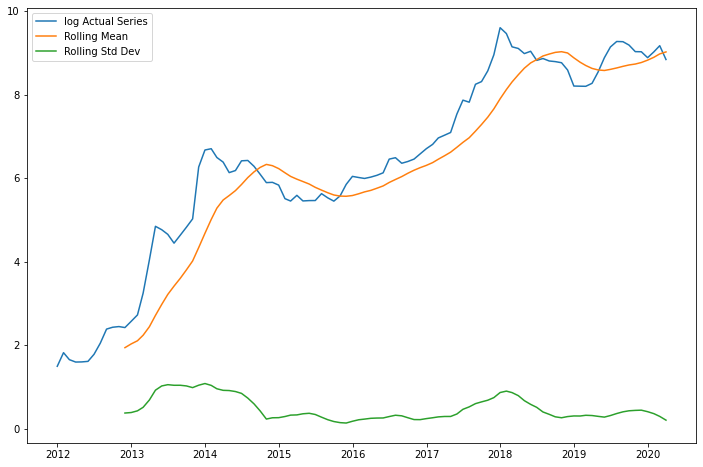

In [11]:
# Use a log transformation over the series
data_train_log = np.log(data_train)

# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean = data_train_log.rolling(window = 12).mean()
rolstd = data_train_log.rolling(window = 12).std()

# Visualize the rolling mean and standard deviation
plt.figure(figsize = (12, 8))
actual = plt.plot(data_train_log, label = "log Actual Series")
rollingmean = plt.plot(rolmean, label = "Rolling Mean") 
rollingstd = plt.plot(rolstd, label ="Rolling Std Dev")
plt.legend()
plt.show()

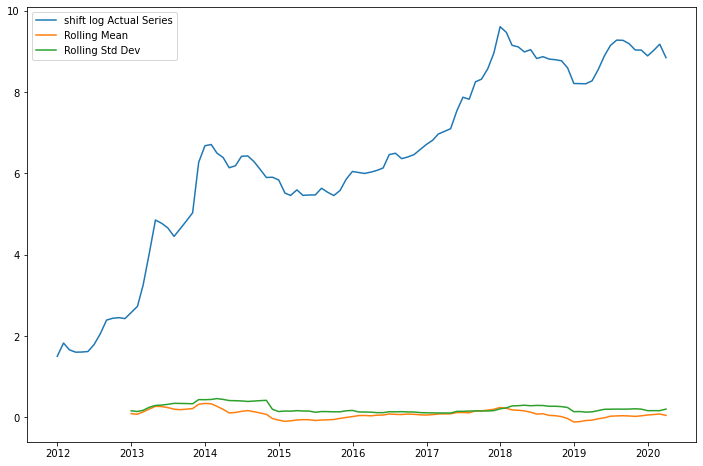

In [12]:
# Apply differencing over the series
data_train_shift = data_train_log - data_train_log.shift(periods = 1)

# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean = data_train_shift.rolling(window = 12).mean()
rolstd = data_train_shift.rolling(window = 12).std()

# Visualize the rolling mean and standard deviation
plt.figure(figsize = (12, 8))
actual = plt.plot(data_train_log, label = "shift log Actual Series")
rollingmean = plt.plot(rolmean, label = "Rolling Mean") 
rollingstd = plt.plot(rolstd, label ="Rolling Std Dev")
plt.legend()
plt.show()

In [13]:
# Drop null values after shift
data_train_shift.dropna(inplace=True)

In [14]:
# Use ADF to test stationarity (Null = Not Stationary)
adftest = adfuller(data_train_shift)
adfoutput = pd.Series(adftest[0:4], index = ["Test Statistic", "p-value", "Lags Used", "No. of Observations"])
for key, value in adftest[4].items():
    adfoutput["Critical Value (%s)"%key] = value
print(adfoutput)

Test Statistic         -6.174833e+00
p-value                 6.669466e-08
Lags Used               0.000000e+00
No. of Observations     9.800000e+01
Critical Value (1%)    -3.498910e+00
Critical Value (5%)    -2.891516e+00
Critical Value (10%)   -2.582760e+00
dtype: float64


**Decompose the time series components**

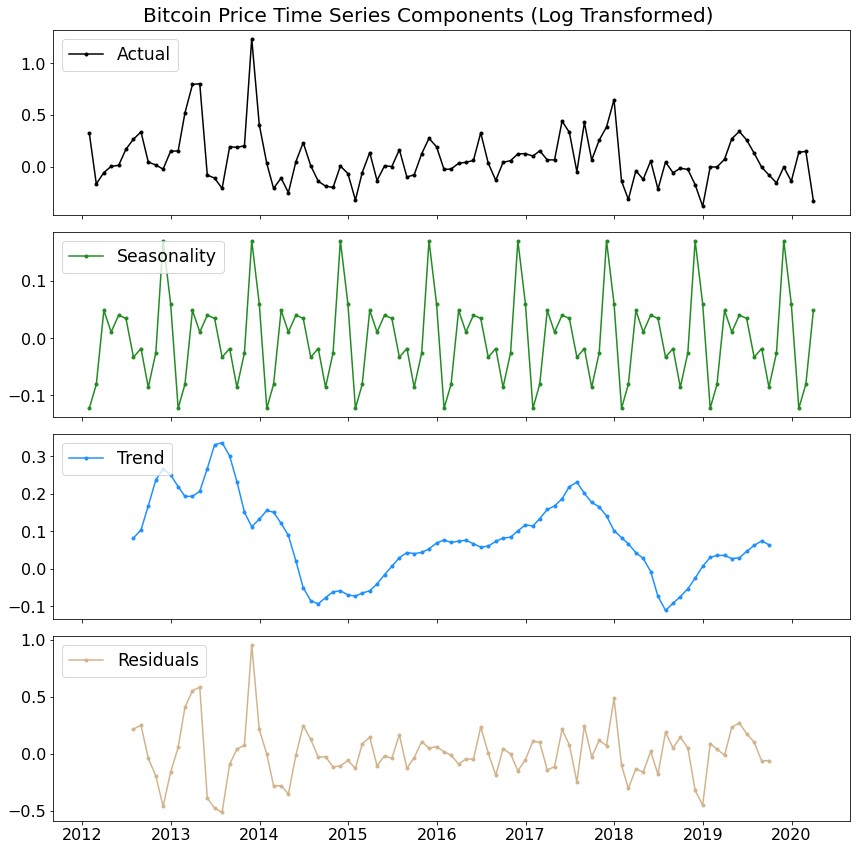

In [15]:
# Decompose the time series components
decomp = seasonal_decompose(data_train_shift)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Visualize components
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axs[0].plot(data_train_shift, label="Actual", marker=".", color="black")
axs[0].legend(loc="upper left", fontsize="xx-large")
axs[0].tick_params(axis='both', which='major', labelsize=16)  

axs[1].plot(seasonal, label="Seasonality", marker=".", color="forestgreen")
axs[1].legend(loc="upper left", fontsize="xx-large")
axs[1].tick_params(axis='both', which='major', labelsize=16)  

axs[2].plot(trend, label="Trend", marker=".", color="dodgerblue")
axs[2].legend(loc="upper left", fontsize="xx-large")
axs[2].tick_params(axis='both', which='major', labelsize=16)  

axs[3].plot(residual, label="Residuals", marker=".", color="tan")
axs[3].legend(loc="upper left", fontsize="xx-large")
axs[3].tick_params(axis='both', which='major', labelsize=16)  

plt.suptitle("Bitcoin Price Time Series Components (Log Transformed)", fontsize=20)
plt.tight_layout()
plt.show()

**Plot the ACF and PACF**

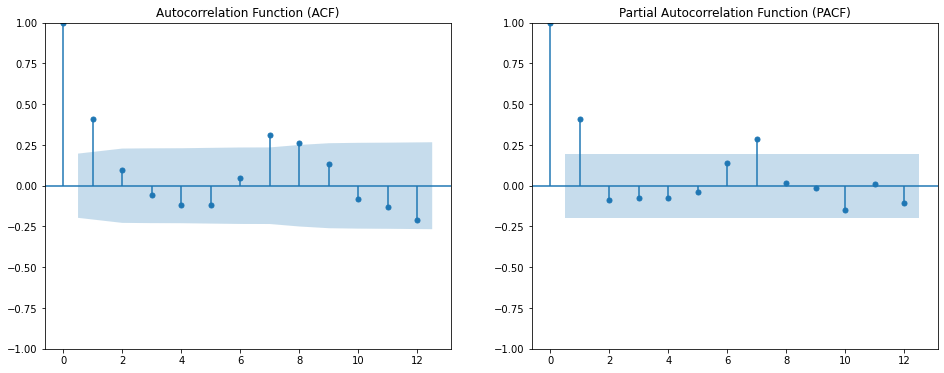

In [16]:
# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the ACF
plot_acf(data_train_shift, lags=12, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(data_train_shift, lags=12, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

# Model Building

**Define plotting functions**

In [18]:
def plot_predictions(data, models, errors_df):
    num_models = len(models)
    rows = math.ceil(num_models / 3)
    cols = min(num_models, 3)

    fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True, sharey=True)
    axs = axs.flatten()
    errors_labels = ["MSE", "RMSE", "MAE", "MAPE", "SMAPE", "Bias"]

    # Check if models is a dictionary of AR or MA models (lag as key), ARMA models ((p, q) as key), ARIMA models ((p, d, q) as key), or SARIMA models ((p, d, q, P, D, Q as key)) 
    if isinstance(list(models.keys())[0], int): # AR or MA models (lag as key)
        for i, (lag, results) in enumerate(models.items()):
            ax = axs[i]
            predict = results.predict(start=0, end=len(data) - 1).fillna(0)
            ax.plot(data, label="Actual", marker=".", color="black")
            ax.plot(predict, label=f"Lag={lag}", marker=".", color="red")
            ax.legend(loc="upper left", fontsize="large")
            ax.set_title(f"Lag={lag}")
            ax.tick_params(labelsize="large")
    elif isinstance(list(models.keys())[0], tuple) and len(list(models.keys())[0]) == 2:  # ARMA models ((p, q) as key)
        for i, ((p, q), results) in enumerate(models.items()):
            ax = axs[i]
            predict = results.predict(start=0, end=len(data) - 1).fillna(0)
            ax.plot(data, label="Actual", marker=".", color="black")
            ax.plot(predict, label=f"p={p}, q={q}", marker=".", color="red")
            ax.legend(loc="upper left", fontsize="large")
            ax.set_title(f"p={p}, q={q}")
            ax.tick_params(labelsize="large")
    elif isinstance(list(models.keys())[0], tuple) and len(list(models.keys())[0]) == 3:  # ARIMA models ((p, d, q) as key)
        for i, ((p, d, q), results) in enumerate(models.items()):
            ax = axs[i]
            predict = results.predict(start=0, end=len(data) - 1).fillna(0)
            ax.plot(data, label="Actual", marker=".", color="black")
            ax.plot(predict, label=f"p={p}, d={d}, q={q}", marker=".", color="red")
            ax.legend(loc="upper left", fontsize="large")
            ax.set_title(f"p={p}, d={d}, q={q}")
            ax.tick_params(labelsize="large")        
    else:  # SARIMA models ((p, d, q, P, D, Q) as key)
        for i, ((p, d, q, P, D, Q), results) in enumerate(models.items()):
            ax = axs[i]
            predict = results.predict(start=0, end=len(data) - 1).fillna(0)
            ax.plot(data, label="Actual", marker=".", color="black")
            ax.plot(predict, label=f"p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}", marker=".", color="red")
            ax.legend(loc="upper left", fontsize="large")
            ax.set_title(f"p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}")
            ax.tick_params(labelsize="large")

    plt.tight_layout()
    plt.show()

In [19]:
# Define function to plot errors
def plot_errors(errors):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot with MSE, RMSE, MAE, and Bias
    ax1 = axs[0]
    ax1.plot(range(len(errors)), errors["MSE"], label="MSE", color="blue", marker=".")
    ax1.plot(range(len(errors)), errors["RMSE"], label="RMSE", color="green", marker=".")
    ax1.plot(range(len(errors)), errors["MAE"], label="MAE", color="orange", marker=".")
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Error")
    ax1.set_title("MSE, RMSE, MAE")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(range(len(errors)), errors["Bias"], label="Bias", color="red", marker=".")
    ax2.set_ylabel("Bias")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="upper right")

    # Right plot with MAPE and SMAPE
    ax3 = axs[1]
    ax3.plot(range(len(errors)), errors["MAPE"], label="MAPE", color="purple", marker=".")
    ax3.set_xlabel("Model")
    ax3.set_ylabel("MAPE")
    ax3.set_title("MAPE, SMAPE")
    ax3.tick_params(axis="y", labelcolor="purple")
    ax3.legend(loc="upper left")

    ax4 = ax3.twinx()
    ax4.plot(range(len(errors)), errors["SMAPE"], label="SMAPE", color="brown", marker=".")
    ax4.set_ylabel("SMAPE")
    ax4.tick_params(axis="y", labelcolor="brown")
    ax4.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # Display error metrics table
    print(errors)

**AR Models - Use log transformed shifted data**

In [20]:
# Generate AR models for different lag values
lags = range(1, 13)
ar_models = {}
ar_errors = {"Lag": [], "MSE": [], "RMSE": [], "MAE": [], "MAPE": [], "SMAPE": [], "Bias": [], "AIC": []}

for lag in lags:
    ar_model = AutoReg(data_train_shift, lags=lag)
    ar_results = ar_model.fit()
    ar_models[lag] = ar_results
    
    # Generate predictions
    predict = ar_results.predict(start=0, end=len(data_train_shift) - 1).fillna(0)
    
    # Calculate error metrics
    mse = mean_squared_error(predict, data_train_shift["Close"])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predict, data_train_shift["Close"])
    actual = data_train["Close"].iloc[lag - 1:]
    mape = np.mean(np.abs((actual - predict) / actual)) * 100
    smape = np.mean(2 * np.abs(predict - actual) / (np.abs(actual) + np.abs(predict))) * 100
    bias = np.mean(actual - predict)
    
    # Append error metrics to the dictionary
    ar_errors["Lag"].append(lag)
    ar_errors["MSE"].append(mse)
    ar_errors["RMSE"].append(rmse)
    ar_errors["MAE"].append(mae)
    ar_errors["MAPE"].append(mape)
    ar_errors["SMAPE"].append(smape)
    ar_errors["Bias"].append(bias)
    
    # Calculate and append AIC
    aic = ar_results.aic
    ar_errors["AIC"].append(aic)

# Store errors as dataframe
ar_errors_df = pd.DataFrame(ar_errors)    

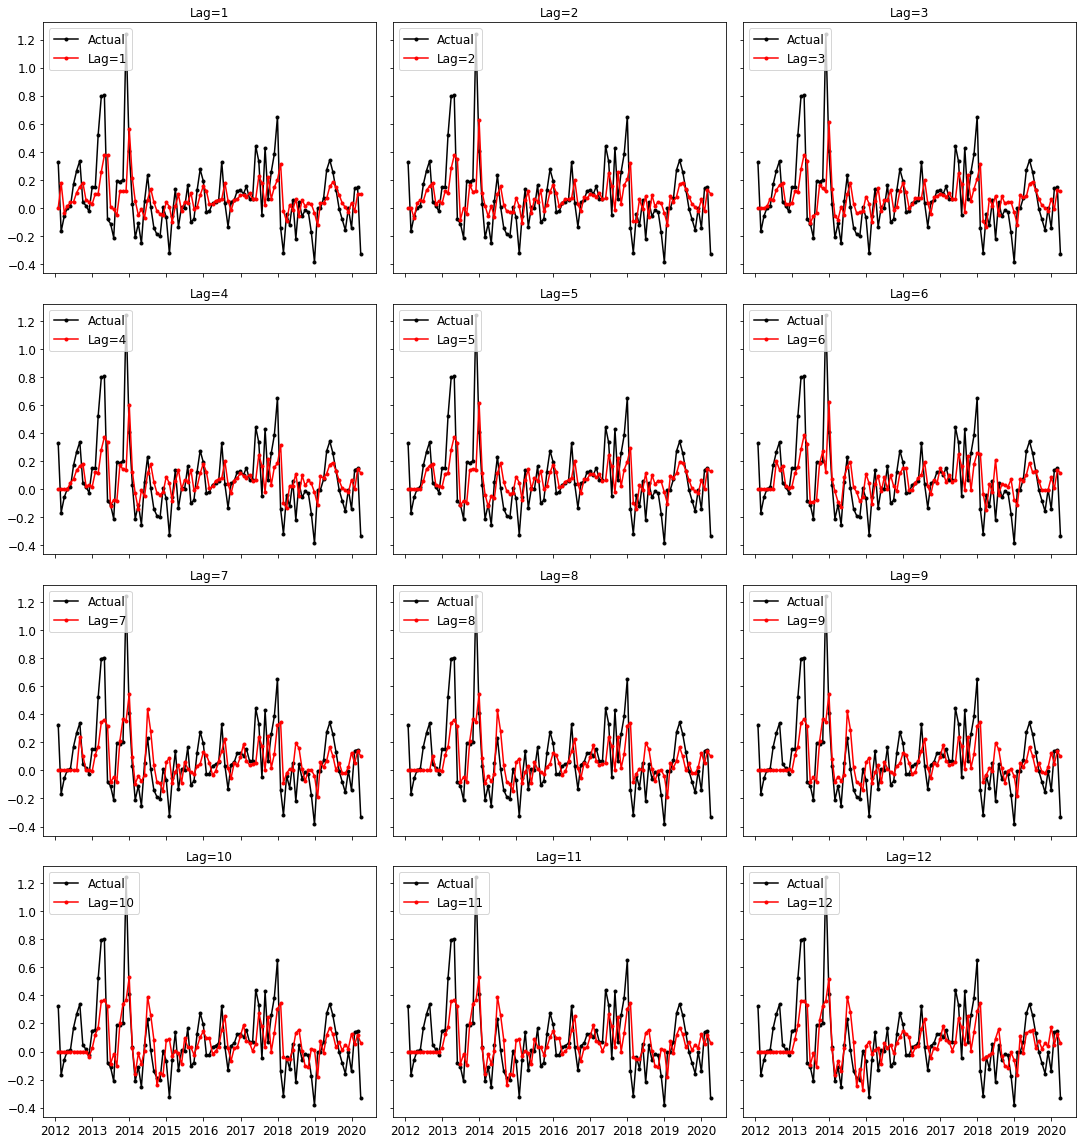

In [21]:
# Call function to plot predictions
plot_predictions(data_train_shift, ar_models, ar_errors_df)

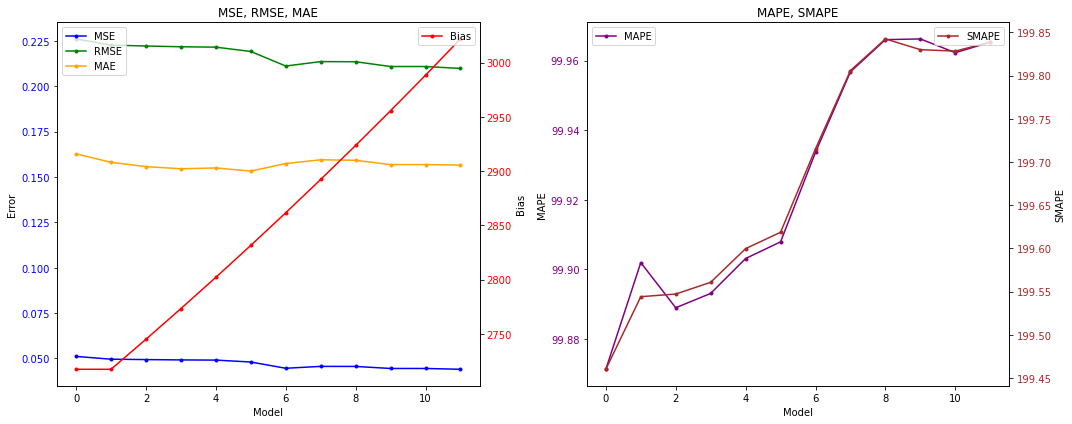

    Lag       MSE      RMSE       MAE       MAPE       SMAPE         Bias       AIC
0     1  0.051131  0.226121  0.162786  99.871323  199.460057  2717.365789 -8.360552
1     2  0.049595  0.222700  0.158110  99.901966  199.544081  2717.364099 -8.807436
2     3  0.049381  0.222219  0.155735  99.888990  199.547155  2745.028365 -6.132384
3     4  0.049195  0.221798  0.154561  99.893114  199.560756  2773.273509 -3.339679
4     5  0.049098  0.221580  0.154997  99.903138  199.599748  2802.110232 -0.377353
5     6  0.048047  0.219196  0.153294  99.907921  199.618653  2831.555528  0.119963
6     7  0.044597  0.211180  0.157421  99.933659  199.715325  2861.627666 -5.379958
7     8  0.045634  0.213621  0.159515  99.956773  199.805838  2892.337270 -2.365232
8     9  0.045602  0.213546  0.159226  99.965994  199.842483  2923.691469  0.764041
9    10  0.044481  0.210906  0.156846  99.966205  199.830031  2955.700166  1.584313
10   11  0.044484  0.210913  0.156875  99.962254  199.828373  2988.414229  4

In [22]:
# Call function to plot errors
plot_errors(ar_errors_df)

**MA Models - Use log transformed shifted data**

In [23]:
# Generate MA models for different lag values
lags = range(1, 13)
ma_models = {}
ma_errors = {"Lag": [], "MSE": [], "RMSE": [], "MAE": [], "MAPE": [], "SMAPE": [], "Bias": [], "AIC": []}

for lag in lags:
    ma_model = ARIMA(data_train_shift, order=(0, 0, lag))
    ma_results = ma_model.fit()
    ma_models[lag] = ma_results
    
    # Generate predictions
    predict = ma_results.predict(start=0, end=len(data_train_shift) - 1).fillna(0)
    
    # Calculate error metrics
    mse = mean_squared_error(predict, data_train_shift["Close"])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predict, data_train_shift["Close"])
    actual = data_train["Close"].iloc[lag - 1:]
    mape = np.mean(np.abs((actual - predict) / actual)) * 100
    smape = np.mean(2 * np.abs(predict - actual) / (np.abs(actual) + np.abs(predict))) * 100
    bias = np.mean(actual - predict)
    
    # Append error metrics to the dictionary
    ma_errors["Lag"].append(lag)
    ma_errors["MSE"].append(mse)
    ma_errors["RMSE"].append(rmse)
    ma_errors["MAE"].append(mae)
    ma_errors["MAPE"].append(mape)
    ma_errors["SMAPE"].append(smape)
    ma_errors["Bias"].append(bias)
    
    # Calculate and append AIC
    aic = ma_results.aic
    ma_errors["AIC"].append(aic)

# Store errors as dataframe
ma_errors_df = pd.DataFrame(ma_errors)    

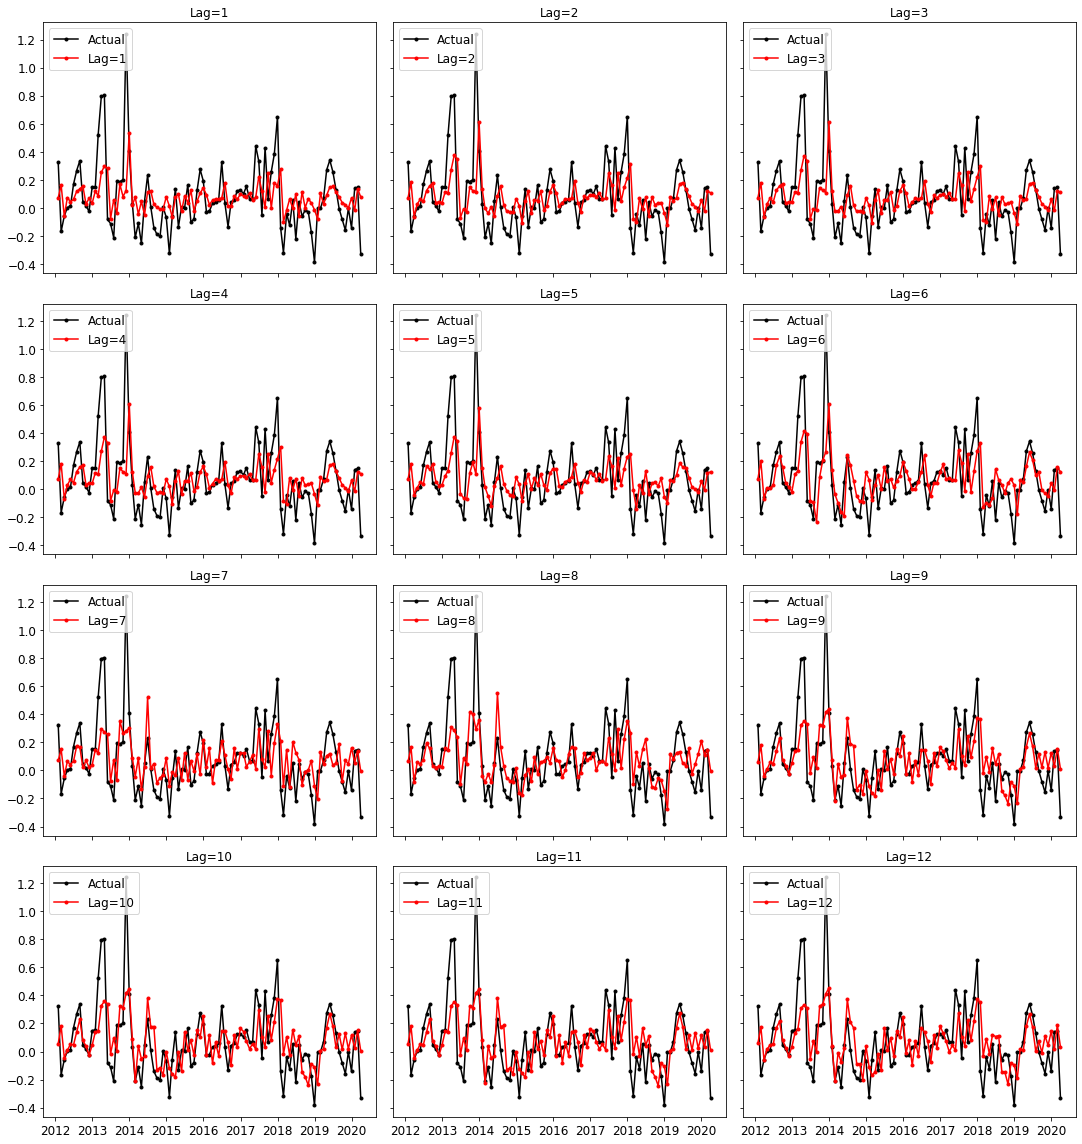

In [24]:
# Call function to plot predictions
plot_predictions(data_train_shift, ma_models, ma_errors_df)

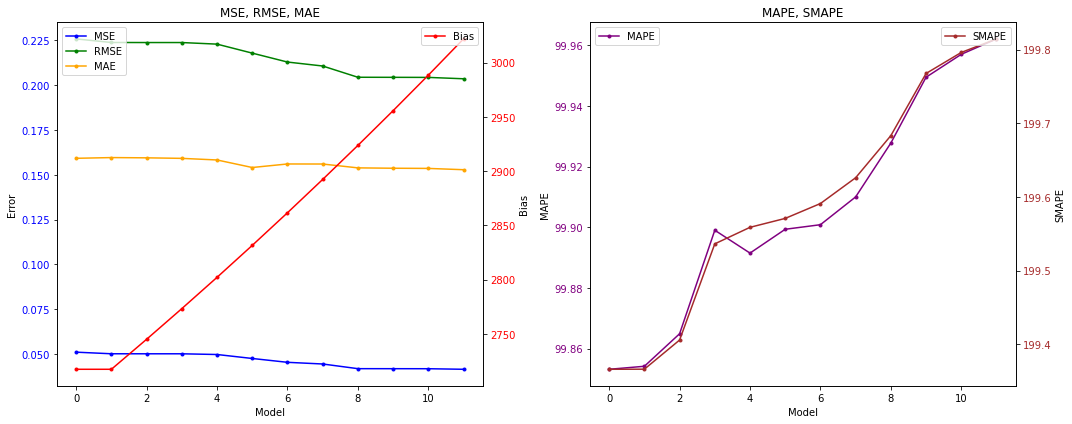

    Lag       MSE      RMSE       MAE       MAPE       SMAPE         Bias        AIC
0     1  0.051020  0.225876  0.159235  99.853156  199.366188  2717.361608  -7.675045
1     2  0.050125  0.223887  0.159640  99.854149  199.366320  2717.361407  -7.422849
2     3  0.050111  0.223855  0.159500  99.864869  199.405853  2745.026996  -5.453278
3     4  0.050110  0.223852  0.159200  99.899013  199.536380  2773.273959  -3.457331
4     5  0.049713  0.222964  0.158307  99.891478  199.558789  2802.110110  -2.206241
5     6  0.047501  0.217946  0.154099  99.899336  199.570903  2831.553692  -4.637175
6     7  0.045354  0.212966  0.156071  99.900840  199.591072  2861.624266  -6.990669
7     8  0.044418  0.210757  0.156045  99.910007  199.626058  2892.331184  -6.953708
8     9  0.041810  0.204476  0.153894  99.927778  199.683206  2923.687281 -11.489293
9    10  0.041795  0.204438  0.153690  99.949486  199.767549  2955.698280  -9.545519
10   11  0.041777  0.204393  0.153591  99.957038  199.796068  298

In [25]:
# Call function to plot errors
plot_errors(ma_errors_df)

**ARMA Models - Use log transformed shifted data**

In [26]:
# Generate ARMA models for different p,q values
p_values = range(1, 13)
q_values = range(1, 13)

arma_models = {}
arma_errors = {"p": [], "q": [], "MSE": [], "RMSE": [], "MAE": [], "MAPE": [], "SMAPE": [], "Bias": [], "AIC": []}

for p in p_values:
    for q in q_values:
        arma_model = ARIMA(data_train_shift, order=(p, 0, q))
        arma_results = arma_model.fit()
        arma_models[(p, q)] = arma_results

        # Generate predictions
        predict = arma_results.predict(start=0, end=len(data_train_shift) - 1).fillna(0)

        # Calculate error metrics
        mse = mean_squared_error(predict, data_train_shift["Close"])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(predict, data_train_shift["Close"])
        actual = data_train["Close"].iloc[q - 1:]
        mape = np.mean(np.abs((actual - predict) / actual)) * 100
        smape = np.mean(2 * np.abs(predict - actual) / (np.abs(actual) + np.abs(predict))) * 100
        bias = np.mean(actual - predict)

        # Append error metrics to the dictionary
        arma_errors["p"].append(p)
        arma_errors["q"].append(q)
        arma_errors["MSE"].append(mse)
        arma_errors["RMSE"].append(rmse)
        arma_errors["MAE"].append(mae)
        arma_errors["MAPE"].append(mape)
        arma_errors["SMAPE"].append(smape)
        arma_errors["Bias"].append(bias)

        # Calculate and append AIC
        aic = arma_results.aic
        arma_errors["AIC"].append(aic)

# Create DataFrame from error metrics
arma_errors_df = pd.DataFrame(arma_errors)

In [27]:
# Filter the DataFrame based on AIC values
filtered_arma_errors_df = arma_errors_df[arma_errors_df["AIC"] < -9]

# Print the filtered DataFrame
print(filtered_arma_errors_df)

    p   q       MSE      RMSE       MAE       MAPE       SMAPE         Bias        AIC
6   1   7  0.043373  0.208261  0.155393  99.897575  199.576432  2861.624906  -9.582959
8   1   9  0.041806  0.204466  0.153814  99.927394  199.681074  2923.687319  -9.528389
9   1  10  0.040721  0.201795  0.149918  99.958907  199.795442  2955.708917 -10.283701
10  1  11  0.040406  0.201013  0.147265  99.966604  199.820722  2988.427579  -9.187976
17  2   6  0.043768  0.209207  0.150913  99.895199  199.559430  2831.555204  -9.111636
18  2   7  0.042313  0.205702  0.150887  99.899954  199.582219  2861.625229 -10.262303
25  3   2  0.045569  0.213468  0.151603  99.857648  199.360699  2717.360187 -11.176496
30  3   7  0.041026  0.202549  0.152176  99.901859  199.578042  2861.625642 -11.523277
31  3   8  0.040945  0.202350  0.151321  99.907818  199.602733  2892.332432  -9.759395
42  4   7  0.040864  0.202147  0.151326  99.899978  199.569933  2861.625226  -9.853566
86  8   3  0.040841  0.202092  0.147531  99

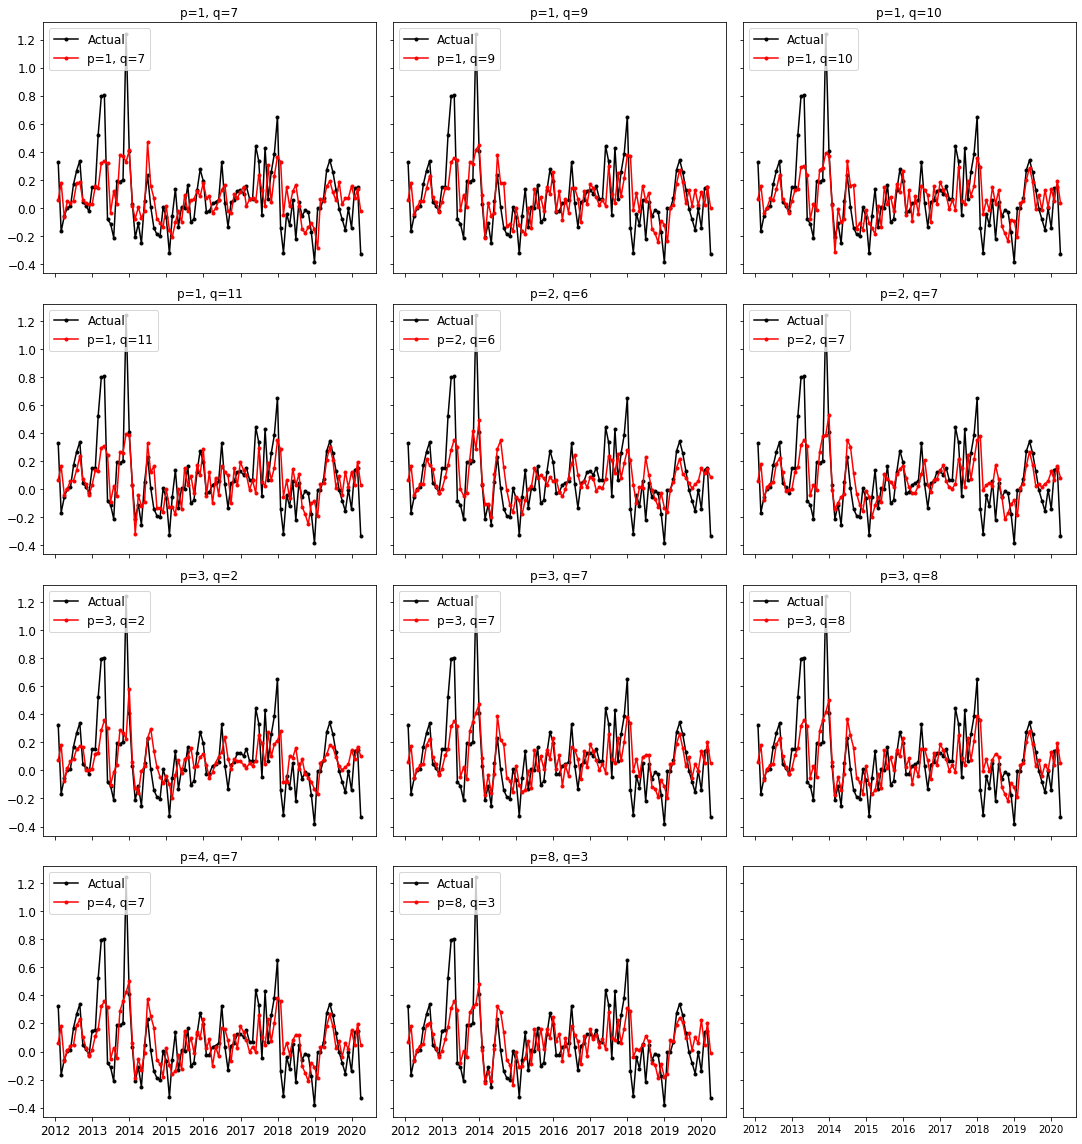

In [28]:
# Filter arma_models to match filtered_arma_errors_df
filtered_arma_models = {key: value for key, value in arma_models.items() if (key[0], key[1]) in zip(filtered_arma_errors_df['p'], filtered_arma_errors_df['q'])}

# Call function to plot predictions
plot_predictions(data_train_shift, filtered_arma_models, filtered_arma_errors_df)

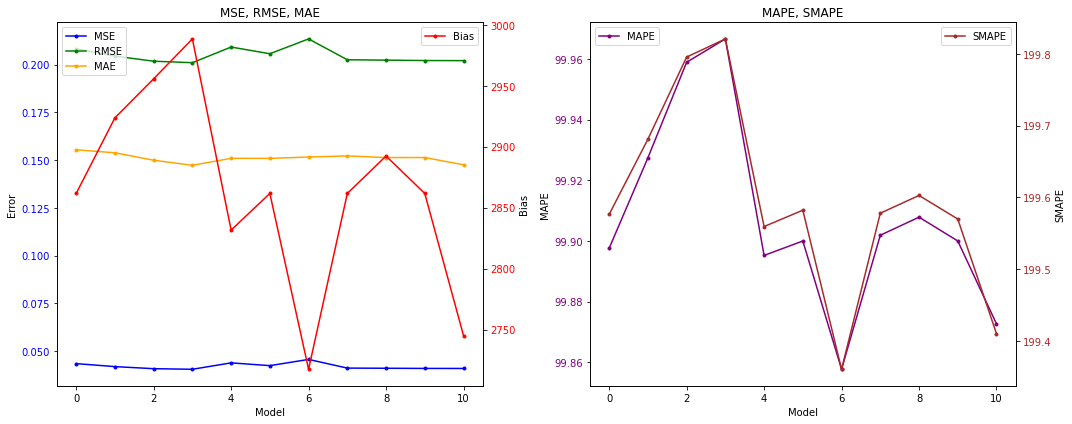

    p   q       MSE      RMSE       MAE       MAPE       SMAPE         Bias        AIC
6   1   7  0.043373  0.208261  0.155393  99.897575  199.576432  2861.624906  -9.582959
8   1   9  0.041806  0.204466  0.153814  99.927394  199.681074  2923.687319  -9.528389
9   1  10  0.040721  0.201795  0.149918  99.958907  199.795442  2955.708917 -10.283701
10  1  11  0.040406  0.201013  0.147265  99.966604  199.820722  2988.427579  -9.187976
17  2   6  0.043768  0.209207  0.150913  99.895199  199.559430  2831.555204  -9.111636
18  2   7  0.042313  0.205702  0.150887  99.899954  199.582219  2861.625229 -10.262303
25  3   2  0.045569  0.213468  0.151603  99.857648  199.360699  2717.360187 -11.176496
30  3   7  0.041026  0.202549  0.152176  99.901859  199.578042  2861.625642 -11.523277
31  3   8  0.040945  0.202350  0.151321  99.907818  199.602733  2892.332432  -9.759395
42  4   7  0.040864  0.202147  0.151326  99.899978  199.569933  2861.625226  -9.853566
86  8   3  0.040841  0.202092  0.147531  99

In [29]:
# Call function to plot errors
plot_errors(filtered_arma_errors_df)

**ARIMA Models - Use log transformed unshifted data**

In [30]:
# Generate ARIMA models for different p, d, q values
p_values = range(1, 13)
d_values = range(0, 2)  
q_values = range(1, 13)

arima_models = {}
arima_errors = {"p": [], "d": [], "q": [], "MSE": [], "RMSE": [], "MAE": [], "MAPE": [], "SMAPE": [], "Bias": [], "AIC": []}

for p in p_values:
    for d in d_values:
        for q in q_values:
            arima_model = ARIMA(data_train_log, order=(p, d, q))
            arima_results = arima_model.fit()
            arima_models[(p, d, q)] = arima_results

            # Generate predictions
            predict = arima_results.predict(start=0, end=len(data_train_log) - 1).fillna(0)

            # Calculate error metrics
            mse = mean_squared_error(predict, data_train_log["Close"])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(predict, data_train_log["Close"])
            actual = data_train_log["Close"].iloc[q - 1:]
            mape = np.mean(np.abs((actual - predict) / actual)) * 100
            smape = np.mean(2 * np.abs(predict - actual) / (np.abs(actual) + np.abs(predict))) * 100
            bias = np.mean(actual - predict)

            # Append error metrics to the dictionary
            arima_errors["p"].append(p)
            arima_errors["d"].append(d)
            arima_errors["q"].append(q)
            arima_errors["MSE"].append(mse)
            arima_errors["RMSE"].append(rmse)
            arima_errors["MAE"].append(mae)
            arima_errors["MAPE"].append(mape)
            arima_errors["SMAPE"].append(smape)
            arima_errors["Bias"].append(bias)

            # Calculate and append AIC
            aic = arima_results.aic
            arima_errors["AIC"].append(aic)

# Create DataFrame from error metrics
arima_errors_df = pd.DataFrame(arima_errors)

In [31]:
# Filter the DataFrame based on AIC values 
filtered_arima_errors_df = arima_errors_df[arima_errors_df["AIC"] < -9]

# Print the filtered DataFrame
print(filtered_arima_errors_df)

    p  d  q       MSE      RMSE       MAE      MAPE     SMAPE      Bias        AIC
18  1  1  7  0.066000  0.256905  0.169578  2.631985  2.672344  0.020564 -10.649553
20  1  1  9  0.064429  0.253829  0.166552  2.486038  2.518294  0.018537 -10.605946
42  2  1  7  0.065172  0.255289  0.166213  2.604205  2.644208  0.025382 -10.815847
43  2  1  8  0.065073  0.255093  0.166544  2.545321  2.583043  0.025246  -9.039054
61  3  1  2  0.068423  0.261577  0.167336  2.947318  2.989299  0.022505 -11.432070
65  3  1  6  0.065788  0.256492  0.165718  2.570550  2.608806  0.023247  -9.310114
66  3  1  7  0.064019  0.253019  0.165268  2.607056  2.651012  0.027933 -11.750013
67  3  1  8  0.063842  0.252670  0.164553  2.514988  2.552338  0.024934 -10.252133
90  4  1  7  0.063743  0.252475  0.164172  2.571811  2.611048  0.024696 -10.393123


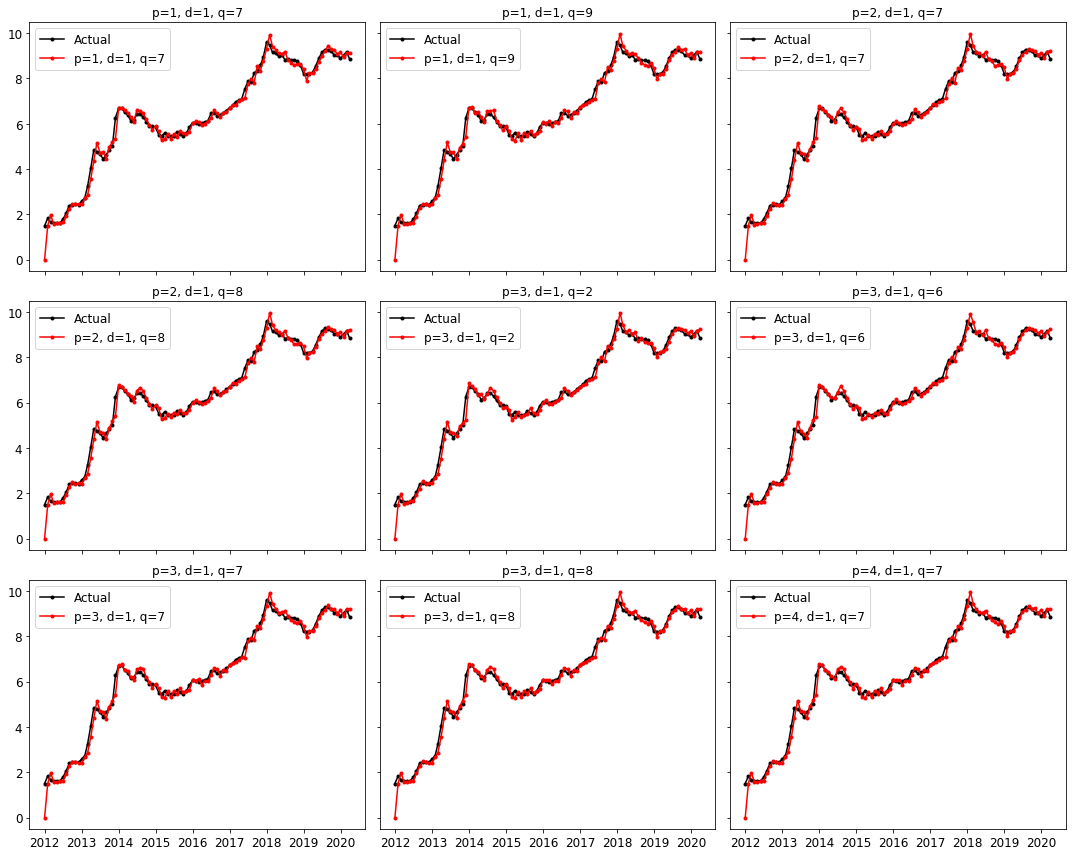

In [32]:
# Filter arima_models to match filtered_arima_errors_df
filtered_arima_models = {key: value for key, value in arima_models.items() if (key[0], key[1], key[2]) in zip(filtered_arima_errors_df['p'], filtered_arima_errors_df['d'], filtered_arima_errors_df['q'])}

# Call function to plot predictions
plot_predictions(data_train_log, filtered_arima_models, filtered_arima_errors_df)

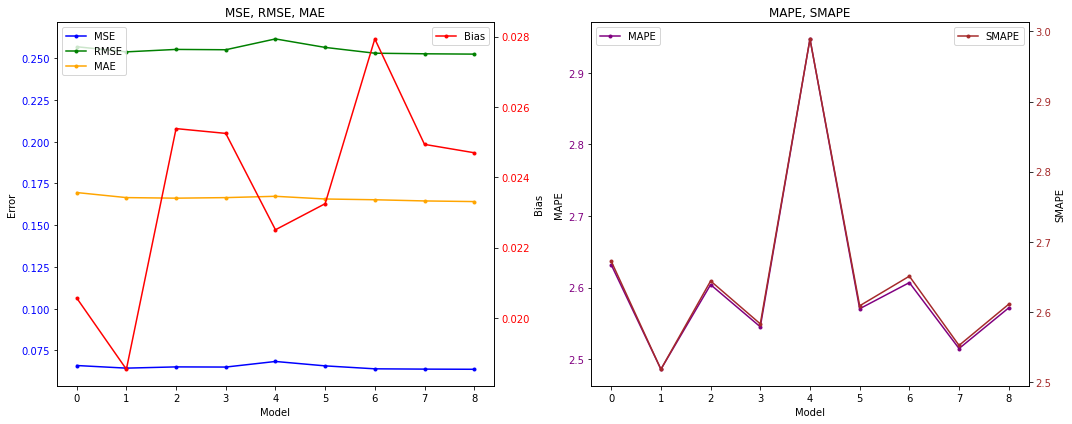

    p  d  q       MSE      RMSE       MAE      MAPE     SMAPE      Bias        AIC
18  1  1  7  0.066000  0.256905  0.169578  2.631985  2.672344  0.020564 -10.649553
20  1  1  9  0.064429  0.253829  0.166552  2.486038  2.518294  0.018537 -10.605946
42  2  1  7  0.065172  0.255289  0.166213  2.604205  2.644208  0.025382 -10.815847
43  2  1  8  0.065073  0.255093  0.166544  2.545321  2.583043  0.025246  -9.039054
61  3  1  2  0.068423  0.261577  0.167336  2.947318  2.989299  0.022505 -11.432070
65  3  1  6  0.065788  0.256492  0.165718  2.570550  2.608806  0.023247  -9.310114
66  3  1  7  0.064019  0.253019  0.165268  2.607056  2.651012  0.027933 -11.750013
67  3  1  8  0.063842  0.252670  0.164553  2.514988  2.552338  0.024934 -10.252133
90  4  1  7  0.063743  0.252475  0.164172  2.571811  2.611048  0.024696 -10.393123


In [33]:
# Call function to plot errors
plot_errors(filtered_arima_errors_df)

**SARIMA Models - Use log transformed unshifted data**

In [34]:
# Generate SARIMA models for different p, d, q values and seasonal components
p_values = range(1, 13)
d_values = range(0, 1)
q_values = range(1, 13)
P_values = range(1, 4)  # Seasonal AR components
D_values = range(0, 1)  # Seasonal differencing
Q_values = range(1, 4)  # Seasonal MA components
seasonal_period = 12  # Monthly data

sarima_models = {}
sarima_errors = {"p": [], "d": [], "q": [], "P": [], "D": [], "Q": [], "MSE": [], "RMSE": [], "MAE": [], "MAPE": [], "SMAPE": [], "Bias": [], "AIC": []}

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            sarima_model = SARIMAX(data_train_log, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
                            sarima_results = sarima_model.fit(disp=False)
                            sarima_models[(p, d, q, P, D, Q)] = sarima_results
                            
                            # Generate predictions
                            predict = sarima_results.predict(start=0, end=len(data_train_log) - 1).fillna(0)
                            
                            # Calculate error metrics
                            mse = mean_squared_error(predict, data_train_log["Close"])
                            rmse = np.sqrt(mse)
                            mae = mean_absolute_error(predict, data_train_log["Close"])
                            actual = data_train_log["Close"].iloc[q - 1:]
                            mape = np.mean(np.abs((actual - predict) / actual)) * 100
                            smape = np.mean(2 * np.abs(predict - actual) / (np.abs(actual) + np.abs(predict))) * 100
                            bias = np.mean(actual - predict)
                            
                            # Append error metrics to the dictionary
                            sarima_errors["p"].append(p)
                            sarima_errors["d"].append(d)
                            sarima_errors["q"].append(q)
                            sarima_errors["P"].append(P)
                            sarima_errors["D"].append(D)
                            sarima_errors["Q"].append(Q)
                            sarima_errors["MSE"].append(mse)
                            sarima_errors["RMSE"].append(rmse)
                            sarima_errors["MAE"].append(mae)
                            sarima_errors["MAPE"].append(mape)
                            sarima_errors["SMAPE"].append(smape)
                            sarima_errors["Bias"].append(bias)
                            
                            # Calculate and append AIC
                            aic = sarima_results.aic
                            sarima_errors["AIC"].append(aic)
                            
                        except:
                            pass # Skip if model fitting fails

# Create DataFrame from error metrics
sarima_errors_df = pd.DataFrame(sarima_errors)

In [35]:
# Filter the DataFrame based on AIC values
filtered_sarima_errors_df = sarima_errors_df[sarima_errors_df['AIC'] < 4]

# Print the filtered DataFrame
print(filtered_sarima_errors_df)

     p  d   q  P  D  Q       MSE      RMSE       MAE      MAPE     SMAPE      Bias       AIC
72   1  0   9  1  0  1  0.066463  0.257803  0.169769  2.535009  2.578162  0.044454  3.109293
180  2  0  10  1  0  1  0.064789  0.254538  0.165647  2.445056  2.482944  0.035472  3.361839
790  9  0   1  1  0  1  0.066174  0.257244  0.169328  3.904838  4.944882  0.045555  3.372951


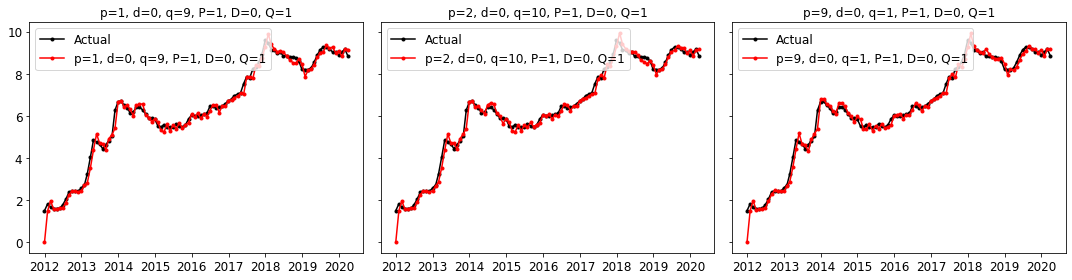

In [36]:
# Filter sarima_models to match filtered_sarima_errors_df
filtered_sarima_models = {key: value for key, value in sarima_models.items() if (key[0], key[1], key[2], key[3], key[4], key[5]) in zip(filtered_sarima_errors_df['p'], filtered_sarima_errors_df['d'], filtered_sarima_errors_df['q'], filtered_sarima_errors_df['P'], filtered_sarima_errors_df['D'], filtered_sarima_errors_df['Q'])}

# Call function to plot predictions
plot_predictions(data_train_log, filtered_sarima_models, filtered_sarima_errors_df)

# Model Comparison

In [38]:
def plot_model_comparison(data, prediction_1, prediction_2, name_1, name_2, name_title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actual and predicted values
    ax.plot(data.index, data["Close"], label="Actual", marker=".", color="black")
    ax.plot(data.index, prediction_1, label=f"Predicted ({name_1})", marker=".", color="blue")
    ax.plot(data.index, prediction_2, label=f"Predicted ({name_2})", marker=".", color="green")

    # Set labels
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.set_title(f"Actual vs Predicted Values for {name_title}")
    ax.legend()

    plt.tight_layout()
    plt.show()

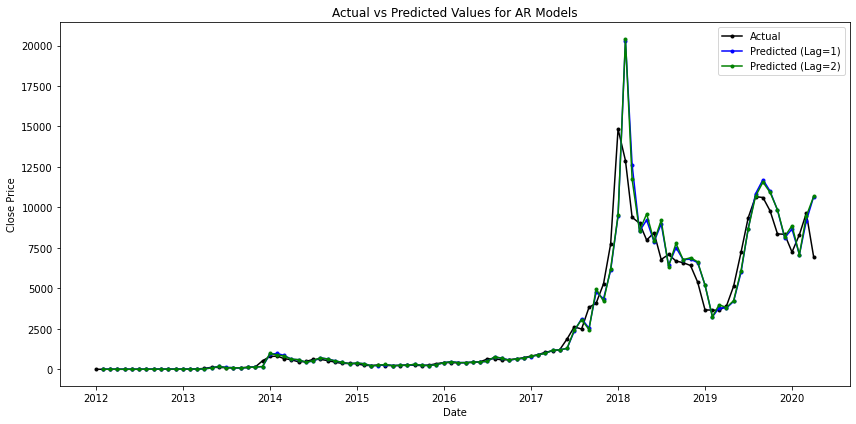

In [39]:
# Predictions of the best two AR Models

# Generate predictions using the best AR models for lag 1 and lag 2
predict_ar_1 = ar_models[1].predict(start=0, end=len(data_train_shift) - 1).fillna(0)
predict_ar_2 = ar_models[2].predict(start=0, end=len(data_train_shift) - 1).fillna(0)

# Inverse difference
predict_ar_1_inverse_diff = predict_ar_1 + data_train_log.shift(periods=1)["Close"]
predict_ar_2_inverse_diff = predict_ar_2 + data_train_log.shift(periods=1)["Close"]

# Inverse log transform the predictions
predict_ar_1_inverse = np.exp(predict_ar_1_inverse_diff)
predict_ar_2_inverse = np.exp(predict_ar_2_inverse_diff)

plot_model_comparison(data_train, predict_ar_1_inverse, predict_ar_2_inverse, "Lag=1", "Lag=2", "AR Models")

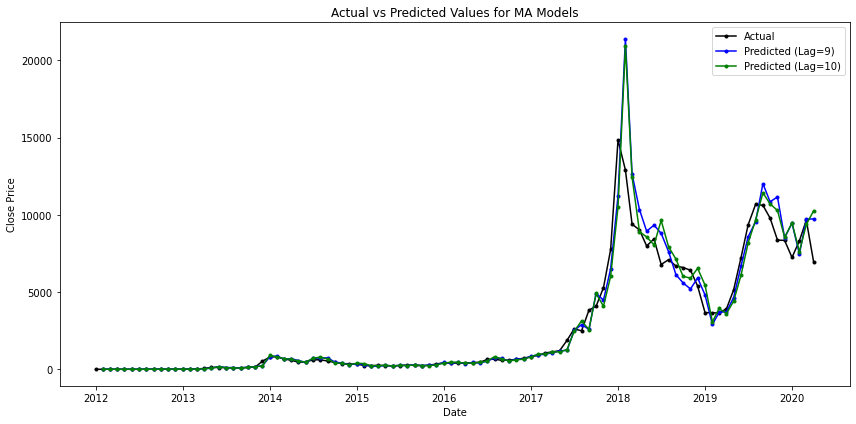

In [40]:
# Predictions of the best two MA Models

# Generate predictions using the best MA models for lag 9 and lag 10
predict_ma_1 = ma_models[9].predict(start=0, end=len(data_train_shift) - 1).fillna(0)
predict_ma_2 = ar_models[10].predict(start=0, end=len(data_train_shift) - 1).fillna(0)

# Inverse difference
predict_ma_1_inverse_diff = predict_ma_1 + data_train_log.shift(periods=1)["Close"]
predict_ma_2_inverse_diff = predict_ma_2 + data_train_log.shift(periods=1)["Close"]

# Inverse log transform the predictions
predict_ma_1_inverse = np.exp(predict_ma_1_inverse_diff)
predict_ma_2_inverse = np.exp(predict_ma_2_inverse_diff)

plot_model_comparison(data_train, predict_ma_1_inverse, predict_ma_2_inverse, "Lag=9", "Lag=10", "MA Models")

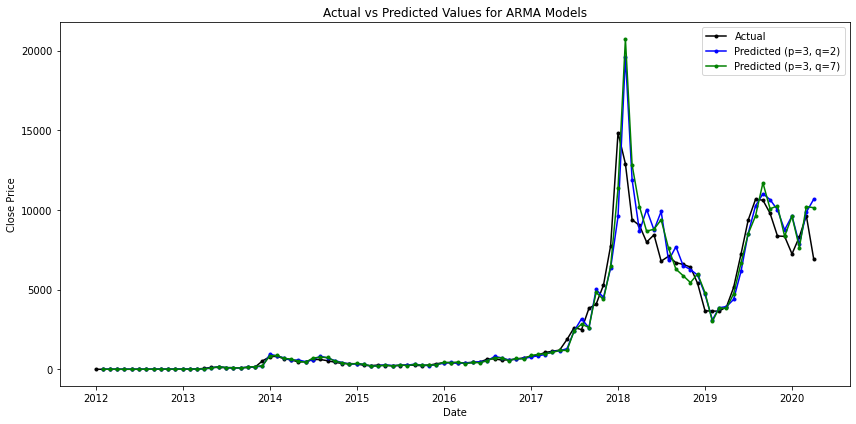

In [41]:
# Predictions of the best two ARMA Models

# Generate predictions using the best ARMA models for (p=3, q=2) and (p=3, q=7)
predict_arma_1 = arma_models[(3, 2)].predict(start=0, end=len(data_train_shift) - 1).fillna(0)
predict_arma_2 = arma_models[(3, 7)].predict(start=0, end=len(data_train_shift) - 1).fillna(0)

# Inverse difference
predict_arma_1_inverse_diff = predict_arma_1 + data_train_log.shift(periods=1)["Close"]
predict_arma_2_inverse_diff = predict_arma_2 + data_train_log.shift(periods=1)["Close"]

# Inverse log transform the predictions
predict_arma_1_inverse = np.exp(predict_arma_1_inverse_diff)
predict_arma_2_inverse = np.exp(predict_arma_2_inverse_diff)

plot_model_comparison(data_train, predict_arma_1_inverse, predict_arma_2_inverse, "p=3, q=2", "p=3, q=7", "ARMA Models")

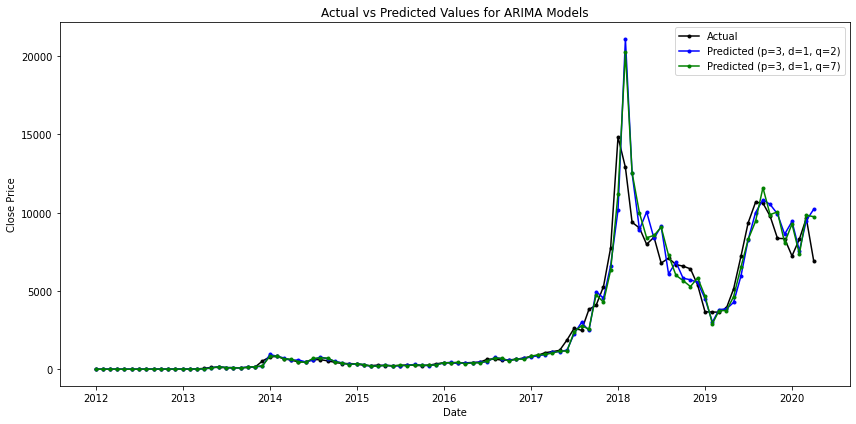

In [42]:
# Predictions of the best two ARIMA Models

# Generate predictions using the best ARIMA models
predict_arima_1 = arima_models[(3, 1, 2)].predict(start=0, end=len(data_train) - 1).fillna(0)
predict_arima_2 = arima_models[(3, 1, 7)].predict(start=0, end=len(data_train) - 1).fillna(0)

# Reverse the log transformation
predict_arima_1_original = np.exp(predict_arima_1)
predict_arima_2_original = np.exp(predict_arima_2)

plot_model_comparison(data_train, predict_arima_1_original, predict_arima_2_original, "p=3, d=1, q=2", "p=3, d=1, q=7", "ARIMA Models")

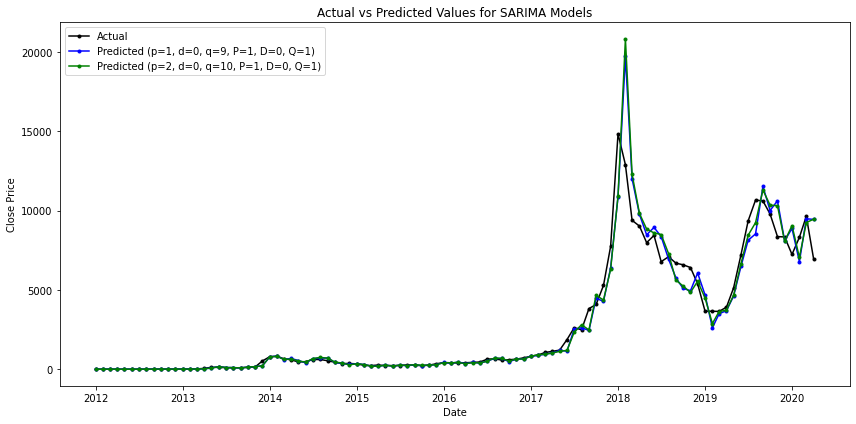

In [43]:
# Predictions of the best two SARIMA Models

# Generate predictions using the best SARIMA models
predict_sarima_1 = sarima_models[(1, 0, 9, 1, 0, 1)].predict(start=0, end=len(data_train) - 1).fillna(0)
predict_sarima_2 = sarima_models[(2, 0, 10, 1, 0, 1)].predict(start=0, end=len(data_train) - 1).fillna(0)

# Reverse the log transformation
predict_sarima_1_original = np.exp(predict_sarima_1)
predict_sarima_2_original = np.exp(predict_sarima_2)

plot_model_comparison(data_train, predict_sarima_1_original, predict_sarima_2_original, "p=1, d=0, q=9, P=1, D=0, Q=1", "p=2, d=0, q=10, P=1, D=0, Q=1", "SARIMA Models")

# Forecast for the 12 months of test data

In [44]:
# Prepare the test data
data_test_log = np.log(data_test)
data_test_shift = data_test_log - data_test_log.shift(periods=1)
data_test_shift.dropna(inplace=True)
first_test_entry_log = data_test_log.iloc[0]

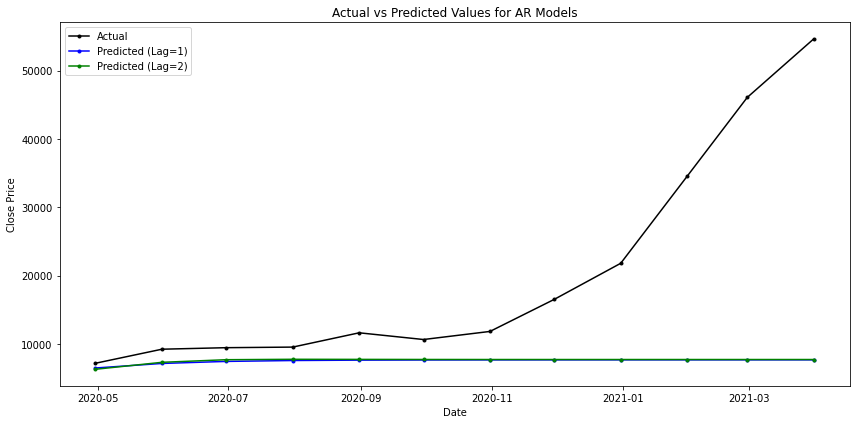

In [45]:
# Predictions of the best two AR Models

# Generate predictions using the best AR models for lag 1 and lag 2
predict_ar_1 = ar_models[1].forecast(steps=12)
predict_ar_2 = ar_models[2].forecast(steps=12)

# Align indices
predict_ar_1.index = pd.date_range(start=predict_ar_1.index[0], periods=len(predict_ar_1), freq="M")
predict_ar_2.index = pd.date_range(start=predict_ar_2.index[0], periods=len(predict_ar_2), freq="M")

# Add value corresponding to first entry
predict_ar_1 = predict_ar_1 + first_test_entry_log["Close"]
predict_ar_2 = predict_ar_2 + first_test_entry_log["Close"]

# Inverse log transform the predictions
predict_ar_1_inverse = np.exp(predict_ar_1)
predict_ar_2_inverse = np.exp(predict_ar_2)

plot_model_comparison(data_test, predict_ar_1_inverse, predict_ar_2_inverse, "Lag=1", "Lag=2", "AR Models")

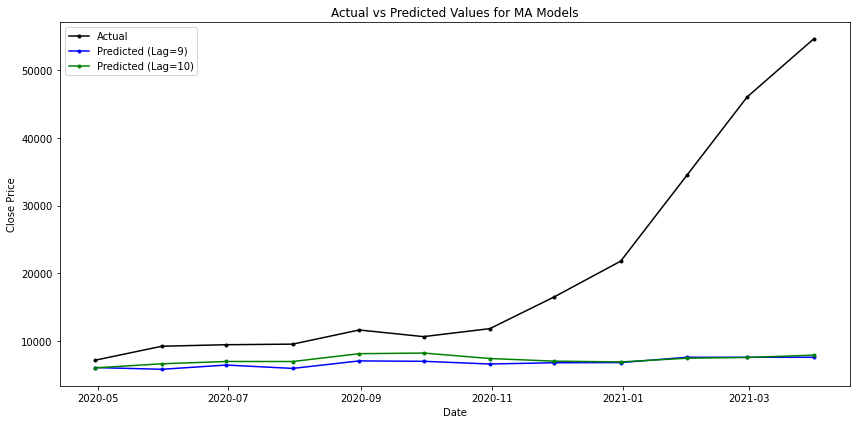

In [46]:
# Predictions of the best two MA Models

# Generate predictions using the best MA models for lag 9 and lag 10
predict_ma_1 = ma_models[9].forecast(steps=12)
predict_ma_2 = ar_models[10].forecast(steps=12)

# Align indices
predict_ma_1.index = pd.date_range(start=predict_ma_1.index[0], periods=len(predict_ma_1), freq="M")
predict_ma_2.index = pd.date_range(start=predict_ma_2.index[0], periods=len(predict_ma_2), freq="M")

# Add value corresponding to first entry
predict_ma_1 = predict_ma_1 + first_test_entry_log["Close"]
predict_ma_2 = predict_ma_2 + first_test_entry_log["Close"]

# Inverse log transform the predictions
predict_ma_1_inverse = np.exp(predict_ma_1)
predict_ma_2_inverse = np.exp(predict_ma_2)

plot_model_comparison(data_test, predict_ma_1_inverse, predict_ma_2_inverse, "Lag=9", "Lag=10", "MA Models")

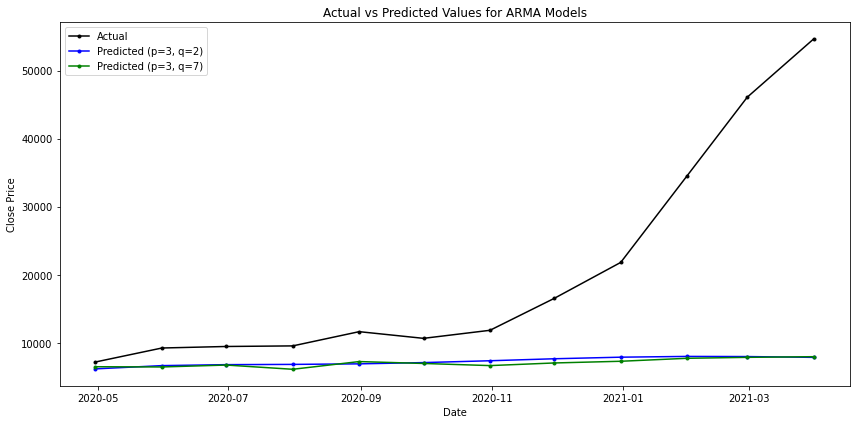

In [50]:
# Predictions of the best two ARMA Models

# Generate predictions using the best ARMA models for (p=3, q=2) and (p=3, q=7)
predict_arma_1 = arma_models[(3, 2)].forecast(steps=12)
predict_arma_2 = arma_models[(3, 7)].forecast(steps=12)

# Align indices
predict_arma_1.index = pd.date_range(start=predict_arma_1.index[0], periods=len(predict_arma_1), freq="M")
predict_arma_2.index = pd.date_range(start=predict_arma_2.index[0], periods=len(predict_arma_2), freq="M")

# Add value corresponding to first entry
predict_arma_1 = predict_arma_1 + first_test_entry_log["Close"]
predict_arma_2 = predict_arma_2 + first_test_entry_log["Close"]

# Inverse log transform the predictions
predict_arma_1_inverse = np.exp(predict_arma_1)
predict_arma_2_inverse = np.exp(predict_arma_2)

plot_model_comparison(data_test, predict_arma_1_inverse, predict_arma_2_inverse, "p=3, q=2", "p=3, q=7", "ARMA Models")

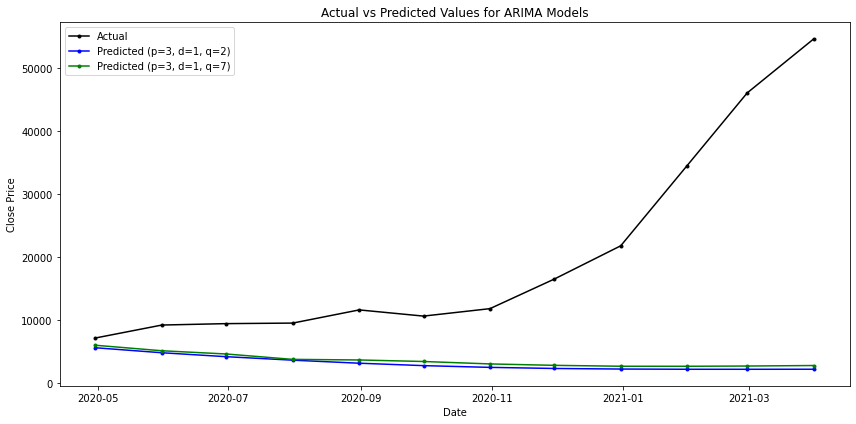

In [48]:
# Predictions of the best two ARIMA Models

# Generate predictions using the best ARIMA models
predict_arima_1 = arima_models[(3, 1, 2)].forecast(steps=12)
predict_arima_2 = arima_models[(3, 1, 7)].forecast(steps=12)

# Align indices
predict_arima_1.index = pd.date_range(start=predict_arima_1.index[0], periods=len(predict_arima_1), freq="M")
predict_arima_2.index = pd.date_range(start=predict_arima_2.index[0], periods=len(predict_arima_2), freq="M")

# Reverse the log transformation
predict_arima_1_original = np.exp(predict_arima_1)
predict_arima_2_original = np.exp(predict_arima_2)

plot_model_comparison(data_test, predict_arima_1_original, predict_arima_2_original, "p=3, d=1, q=2", "p=3, d=1, q=7", "ARIMA Models")

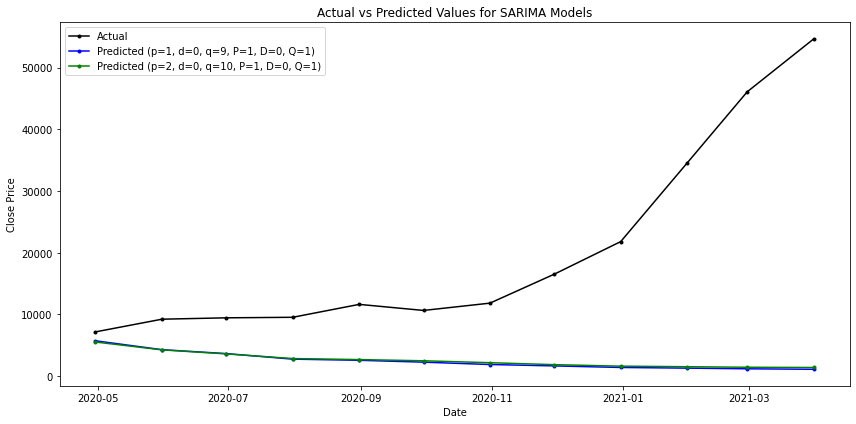

In [49]:
# Predictions of the best two SARIMA Models

# Generate predictions using the best SARIMA models
predict_sarima_1 = sarima_models[(1, 0, 9, 1, 0, 1)].forecast(steps=12)
predict_sarima_2 = sarima_models[(2, 0, 10, 1, 0, 1)].forecast(steps=12)

# Align indices
predict_sarima_1.index = pd.date_range(start=predict_sarima_1.index[0], periods=len(predict_sarima_1), freq="M")
predict_sarima_2.index = pd.date_range(start=predict_sarima_2.index[0], periods=len(predict_sarima_2), freq="M")

# Reverse the log transformation
predict_sarima_1_original = np.exp(predict_sarima_1)
predict_sarima_2_original = np.exp(predict_sarima_2)

plot_model_comparison(data_test, predict_sarima_1_original, predict_sarima_2_original, "p=1, d=0, q=9, P=1, D=0, Q=1", "p=2, d=0, q=10, P=1, D=0, Q=1", "SARIMA Models")